In [1]:
!pip install --disable-pip-version-check -q sagemaker==2.35.0


In [2]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore

sm_boto3 = boto3.client("sagemaker")

sess = sagemaker.Session()

bucket = 'mobucketsagemaker'

region = sess.boto_session.region_name


print(f"S3 bucket: {bucket}")
print(f"region name: {region}")



S3 bucket: mobucketsagemaker
region name: us-east-1


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
!aws s3 cp s3://dlai-practical-data-science/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv ./


Completed 256.0 KiB/6.9 MiB (127.5 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/6.9 MiB (228.2 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/6.9 MiB (340.2 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/6.9 MiB (412.5 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/6.9 MiB (295.9 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/6.9 MiB (355.1 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/6.9 MiB (414.2 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/6.9 MiB (473.4 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/6.9 MiB (532.5 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/6.9 MiB (591.6 KiB/s) with 1 file(s) remaining  
Completed 2.8 MiB/6.9 MiB (650.6 KiB/s) with 1 file(s) remaining  
Completed 3.0 MiB/6.9 MiB (709.8 KiB/s) with 1 file(s) remaining  
Completed 3.2 MiB/6.9 MiB (766.6 KiB/s) with 1 file(s) remaining  
Completed 3.5 MiB/6.9 MiB (825.6 KiB/s) with 1 file(s) remaining  
Completed 3.8 MiB/6.9 MiB (884.4 KiB/s) with 1 file(s) remaini

In [12]:
path = './womens_clothing_ecommerce_reviews_transformed.csv'

df = pd.read_csv(path)
df.head()

,sentiment,review_body,product_category
0,1,If this product was in petite i would get the...,Blouses
1,1,Love this dress! it's sooo pretty. i happene...,Dresses
2,0,I had such high hopes for this dress and reall...,Dresses
3,1,I love love love this jumpsuit. it's fun fl...,Pants
4,1,This shirt is very flattering to all due to th...,Blouses


In [13]:
df.shape

(22626, 3)

In [15]:
df['sentiment'].value_counts()

sentiment
 1    17433
 0     2823
-1     2370
Name: count, dtype: int64

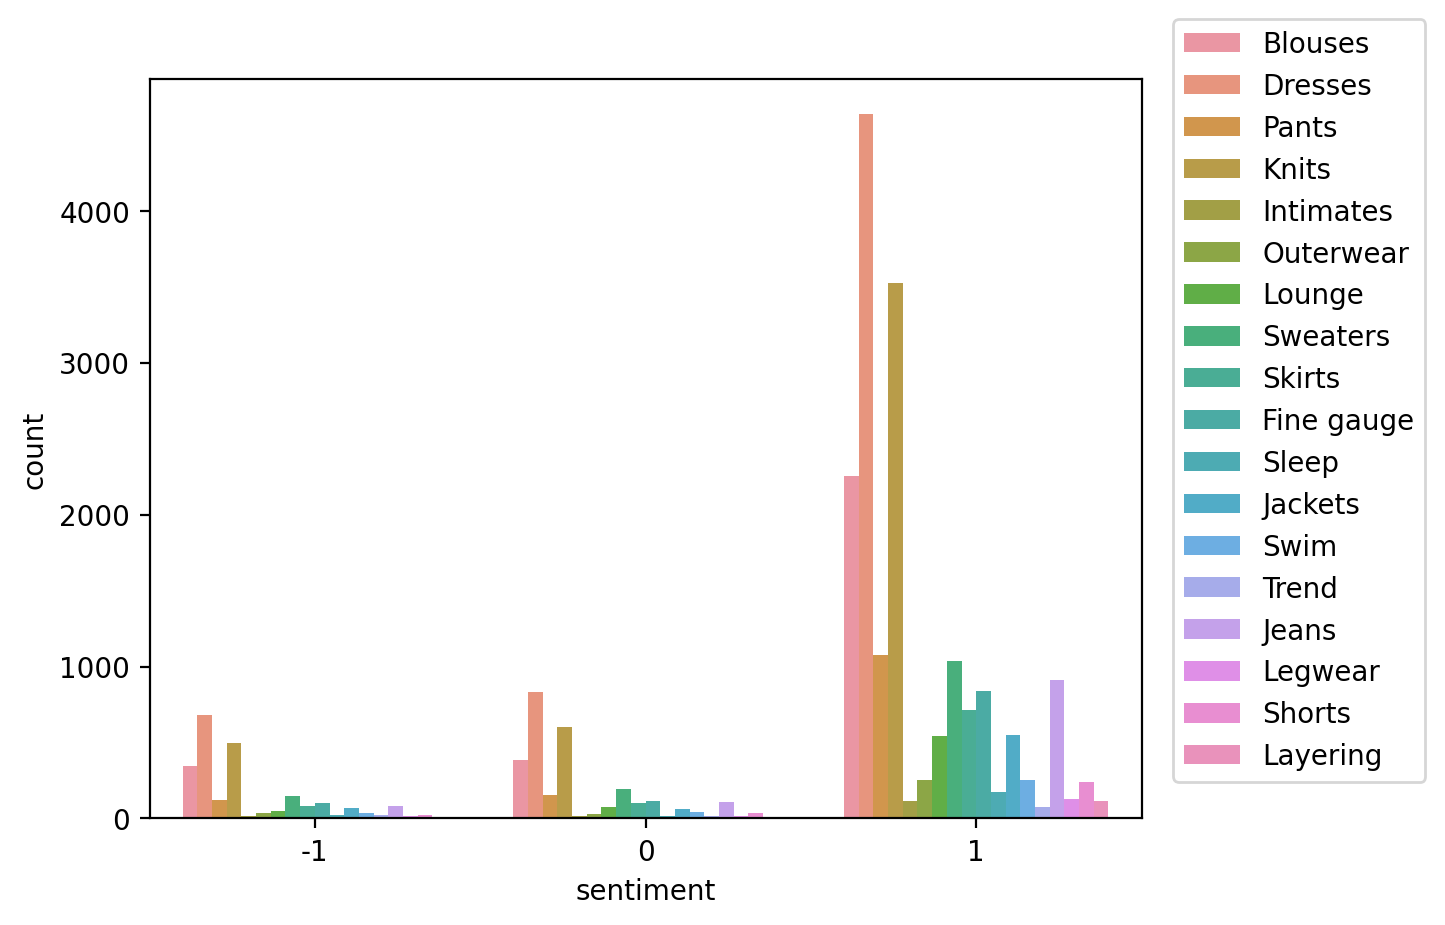

In [17]:
import seaborn as sns

sns.countplot(data  = df, x='sentiment', hue = 'product_category')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.1))
plt.show()

In [18]:
#uploading the dataset to S3 bucket (into a folder bia/unbalanced )

data_s3_uri_unbalanced = sess.upload_data(bucket=bucket,
                                          key_prefix= 'bias/unbalanced',
                                          path  = './womens_clothing_ecommerce_reviews_transformed.csv')

data_s3_uri_unbalanced


's3://mobucketsagemaker/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv'

In [25]:
from sagemaker import clarify

bias_report_unbalanced_output_path = 's3://{}/bias/generated_bias_report/unbalanced'.format(bucket)

data_config_unbalanced = clarify.DataConfig(
    
    s3_data_input_path=data_s3_uri_unbalanced, 
    s3_output_path=bias_report_unbalanced_output_path, 
    label='sentiment', 
    
    headers=df.columns.to_list(),
    dataset_type='text/csv'
)

In [29]:
bias_config_unbalanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='product_category' # sensitive column (facet)
)

In [50]:
role = "arn:aws:iam::461481678519:role/Role"

In [59]:
#to scale the process of data bias detection using two parameters, `instance_count` and `instance_type`.

clarify_processor_unbalanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.r5.16xlarge',
                                                      sagemaker_session=sess)

In [60]:
clarify_processor_unbalanced.run_pre_training_bias(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    data_config=data_config_unbalanced, # Replace None
    data_bias_config=bias_config_unbalanced, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2023-07-21-19-42-44-716
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://mobucketsagemaker/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://mobucketsagemaker/bias/generated_bias_report/unbalanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://mobucketsagemaker/bias/generated_bias_report/unbalanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateProcessingJob operation: The account-level service limit 'ml.r5.16xlarge for processing job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.